In [34]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV , Lasso

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [7]:
train_df = pd.read_csv('train_cleaned.csv')
test_df  = pd.read_csv('test_cleaned.csv')

id = test_df['Id']
train_df.drop('Id',axis = 1, inplace = True)
test_df.drop('Id',axis = 1 , inplace = True)
y_train = train_df['SalePrice']
x_train = train_df.drop('SalePrice', axis = 1)

test_df.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Functional_Min2,BldgType_Twnhs,RoofStyle_Mansard,RoofMatl_CompShg,SaleCondition_Partial,GarageCond_Ex,Functional_Maj2,SaleType_New,GarageType_BuiltIn,Exterior2nd_CBlock
0,3.044522,80,9.360741,5,6,1961,1961,0.000000,6.150603,4.976734,...,0,0,0,1,0,0,0,0,0,0
1,3.044522,81,9.565775,6,6,1958,1958,4.691348,6.828712,0.000000,...,0,0,0,1,0,0,0,0,0,0
2,4.110874,74,9.534668,5,5,1997,1998,0.000000,6.674561,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,4.110874,78,9.208238,6,6,1998,1998,3.044522,6.401917,0.000000,...,0,0,0,1,0,0,0,0,0,0
4,4.795791,43,8.518392,8,5,1992,1992,0.000000,5.575949,0.000000,...,0,0,0,1,0,0,0,0,0,0


<B> RIDGE MODEL </B>

In [18]:
def printFeature(model,x_train, y_train , performCV = True , cvFolds = 10):
    
    model.fit(x_train,y_train)
    feature_importances = model.feature_importances_
    feat_labels = [ x for x in x_train.columns.values]
    feat_imp = pd.Series(feature_importances,feat_labels).sort_values(ascending=False)
    #print(feat_imp.dtypes)
    #plt.bar(feat_labels[:],feat_imp[:])
    plt.ylabel('Feature Importances')
    #plt.show()
    
def modelFit(model,x_train,y_train,performCV = True , cvFolds = 10 , modelReport = False):
    
    model.fit(x_train,y_train)
    x_train_predictions = model.predict(x_train)
    
    if performCV == True :
        cv_score_meanSqError = cross_val_score(model,x_train,y_train,cv= cvFolds,scoring = 'neg_mean_squared_error')
        cv_score_r2 = cross_val_score(model,x_train,y_train,cv= cvFolds,scoring = 'r2')
        
    return np.mean(np.sqrt(-cv_score_meanSqError))  # retutn the RMSE error
      
    if modelReport :
        
        print(" Model Report")
        print(" Mean Squared Error = %.4g" % metrics.mean_squared_error(y_train.values,x_train_predictions))
        print(" R2 score = %.4g" % metrics.r2_score(y_train.values,x_train_predictions))
          
    
        print(" CV Score (Mean Square Error) : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_meanSqError),np.std(cv_score_meanSqError),np.min(cv_score_meanSqError),np.max(cv_score_meanSqError)))
        print(" CV Score ( R square        ) : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_r2),np.std(cv_score_r2),np.min(cv_score_r2),np.max(cv_score_r2)))


The main tuning parameter for the Ridge Model in alpha - a regularization parameter that measures how flexible our model is . THe higher the regularization model, the less prone is our model to overfit. However, it will love its ability it flexiblity and might not capture all of the signal data in the data.

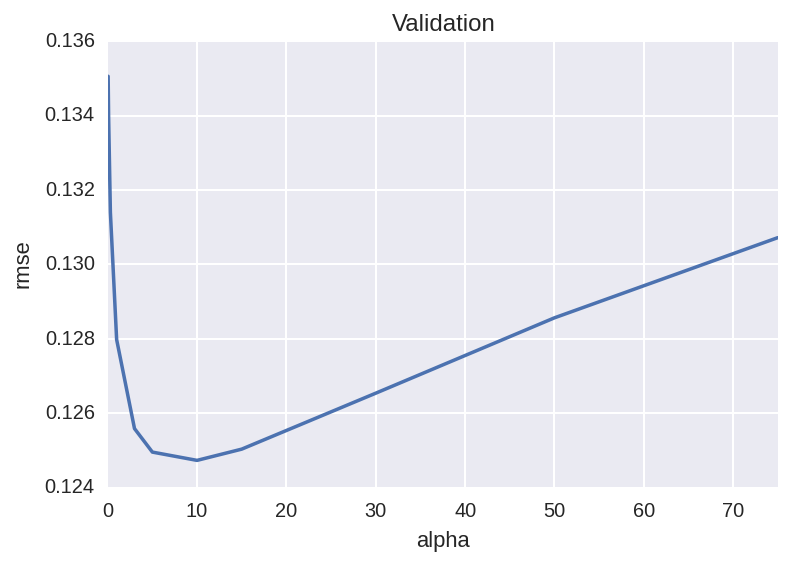

In [25]:
alphas = [0.05,0.1,0.3,1,3,5,10,15,30,50,75]

RMSE_cv = []

for alpha in alphas:
    model = Ridge (alpha = alpha)
    RMSE_cv.append(modelFit(model, x_train,y_train,performCV = True,modelReport=False))

RMSE_cv = pd.Series(RMSE_cv,index = alphas)
RMSE_cv.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()



We choose an alpha value of that minimizes the error.  When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. 

<B> We may verify it by using grid search as well. </B>

In [29]:
from sklearn.grid_search import GridSearchCV

param_test1 =  {'alpha' : [0.05,0.1,0.3,1,3,5,10,15,30,50,75]}
model = Ridge()
gridSearch1 =  GridSearchCV(estimator = model, 
                       param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gridSearch1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=75, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [30]:
gridSearch1.grid_scores_, gridSearch1.best_params_ , gridSearch1.best_score_

([mean: 0.86789, std: 0.02809, params: {'alpha': 0.05},
  mean: 0.87223, std: 0.02750, params: {'alpha': 0.1},
  mean: 0.88096, std: 0.02665, params: {'alpha': 0.3},
  mean: 0.88974, std: 0.02622, params: {'alpha': 1},
  mean: 0.89509, std: 0.02625, params: {'alpha': 3},
  mean: 0.89658, std: 0.02621, params: {'alpha': 5},
  mean: 0.89736, std: 0.02599, params: {'alpha': 10},
  mean: 0.89697, std: 0.02579, params: {'alpha': 15},
  mean: 0.89447, std: 0.02535, params: {'alpha': 30},
  mean: 0.89101, std: 0.02495, params: {'alpha': 50},
  mean: 0.88733, std: 0.02460, params: {'alpha': 75}],
 {'alpha': 10},
 0.8973551848166219)

<B> LASSO Model </B>

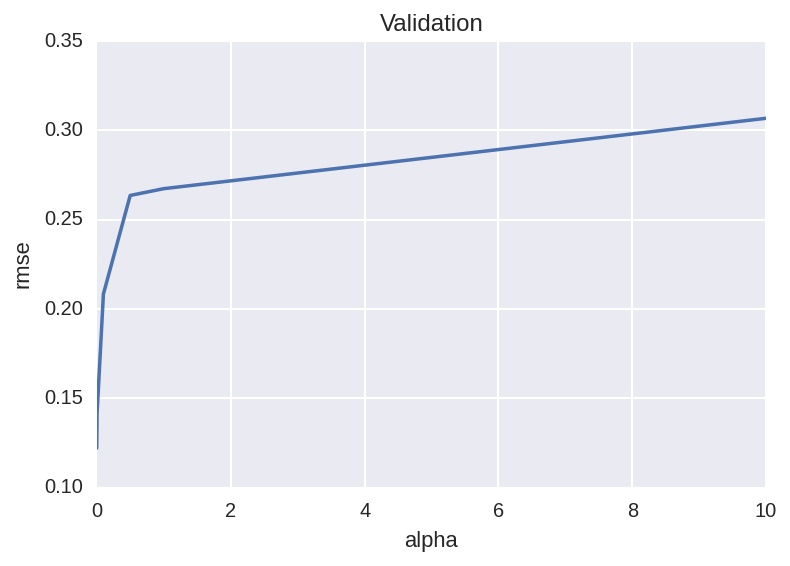

In [40]:
# alphas in Lasso CV are really the inverse or the alphas in Ridge.

alphas = [0.0005,0.005,0.1,0.5,1,10]

RMSE_cv = []

for alpha in alphas:
    model = Lasso (alpha = alpha)
    RMSE_cv.append(modelFit(model, x_train,y_train,performCV = True,modelReport=False))

RMSE_cv = pd.Series(RMSE_cv,index = alphas)
RMSE_cv.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [44]:
param_test1 =  {'alpha' : [0.05,0.1,0.3,1,3,5,10,15,30,50,75]}
model = Lasso()
gridSearch1 =  GridSearchCV(estimator = model, 
                       param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
gridSearch1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [45]:
gridSearch1.grid_scores_, gridSearch1.best_params_ , gridSearch1.best_score_

([mean: 0.78569, std: 0.02626, params: {'alpha': 0.05},
  mean: 0.72288, std: 0.03402, params: {'alpha': 0.1},
  mean: 0.56075, std: 0.04334, params: {'alpha': 0.3},
  mean: 0.54545, std: 0.04021, params: {'alpha': 1},
  mean: 0.44285, std: 0.05020, params: {'alpha': 3},
  mean: 0.41298, std: 0.04719, params: {'alpha': 5},
  mean: 0.40343, std: 0.03923, params: {'alpha': 10},
  mean: 0.38693, std: 0.03216, params: {'alpha': 15},
  mean: 0.29564, std: 0.01661, params: {'alpha': 30},
  mean: 0.07647, std: 0.01297, params: {'alpha': 50},
  mean: -0.00347, std: 0.00513, params: {'alpha': 75}],
 {'alpha': 0.05},
 0.7856863075090943)

In [61]:
param_test2 =  {'alpha' : [0.0005,0.0010,0.005,0.010,0.05,0.10]}
model = Lasso()
gridSearch2 =  GridSearchCV(estimator = model, 
                       param_grid = param_test2, scoring='r2',n_jobs=4,iid=False, cv=5)
gridSearch2.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'alpha': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [62]:
gridSearch2.grid_scores_, gridSearch2.best_params_ , gridSearch2.best_score_

([mean: 0.90322, std: 0.02435, params: {'alpha': 0.0005},
  mean: 0.90194, std: 0.02455, params: {'alpha': 0.001},
  mean: 0.87104, std: 0.02657, params: {'alpha': 0.005},
  mean: 0.84997, std: 0.02637, params: {'alpha': 0.01},
  mean: 0.78569, std: 0.02626, params: {'alpha': 0.05},
  mean: 0.72288, std: 0.03402, params: {'alpha': 0.1}],
 {'alpha': 0.0005},
 0.903222238510699)

<B> Hell Yeah ! Lasso Model performs even better. </B> We will move on to the feature_selection that it does.